# Imports

In [1]:
#supress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import sys
import os

_stderr = sys.stderr
null = open(os.devnull,'wb')

In [2]:
import scanpy as sc
#set some figure parameters for nice display inside jupyternotebooks.
%matplotlib inline
import matplotlib.pyplot as plt

sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(5, 5), facecolor='white')

In [3]:
work_dir = "./data/scenicplus/"
os.makedirs(work_dir, exist_ok=True)

# From SeuratObject to Annadata
As of Feb 2024, both ATAC and RNA analyses are within the same SeuratObject. When converting to H5AD, 

`rna_combined_e12_e14_GSE178546.h5ad`: Current assay is RNA. Gene IDs are expected in `adata.var_names` (e.g. Zfhx4)

`atac_combined_e12_e14_GSE178546.h5ad`: Current assay is ATAC. Peak IDs are expected in `adata.var_names` (e.g. chr1-3412861-3413118).

`adata.obs['ident']`: These are the annotations imported from the Seurat(scRNA-seq)+Signac(scATAC-seq) workflow in R. 

`adata.obs['celltype']`: Results of reclustering, if any. As of Mar 2024, subclustering iRL vs eRL for E12-14. 

### Notes on SeuratObject to Anndata conversion
As of Feb 2024, using Zellkonverter since the CellOracle conversion module is now deprecated. 

# scRNA-seq preprocessing using ScanPy

In [4]:
adata = sc.read_h5ad('./co_input/rna_combined_e12_e14_GSE178546.h5ad')
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 23726 × 21821
    obs: 'orig.ident', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'nucleosome_group', 'TSS.enrichment', 'TSS.percentile', 'high.tss', 'fragments', 'FRiP', 'blacklist_fraction', 'peak_region_fragments', 'pct_reads_in_peaks', 'dataset', 'ATAC_snn_res.1.2', 'seurat_clusters', 'ATAC_snn_res.0.8', 'ATAC_snn_res.0.6', 'nCount_RNA', 'nFeature_RNA', 'predicted.id', 'prediction.score.31', 'prediction.score.46', 'prediction.score.9', 'prediction.score.40', 'prediction.score.1', 'prediction.score.12', 'prediction.score.27', 'prediction.score.18', 'prediction.score.30', 'prediction.score.11', 'prediction.score.2', 'prediction.score.15', 'prediction.score.6', 'prediction.score.22', 'prediction.score.29', 'prediction.score.43', 'prediction.score.19', 'prediction.score.4', 'prediction.score.24', 'prediction.score.21', 'prediction.score.8', 'prediction.score.13', 'prediction.score.35', 'prediction.score.42', 'predict

In [5]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

## Doublet removal 
Optional step: Predict and filter out doublets via Scrublet

In [6]:
# esimates doublets
sc.external.pp.scrublet(adata) 

# filters doublets
adata = adata[adata.obs['predicted_doublet'] == False]

/arc/project/st-dg0ldo-1/jupyter/ScenicPlusEnv/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.19
Detected doublet rate = 6.6%
Estimated detectable doublet fraction = 55.7%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 11.9%


In [7]:
adata

View of AnnData object with n_obs × n_vars = 22154 × 21253
    obs: 'orig.ident', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'nucleosome_group', 'TSS.enrichment', 'TSS.percentile', 'high.tss', 'fragments', 'FRiP', 'blacklist_fraction', 'peak_region_fragments', 'pct_reads_in_peaks', 'dataset', 'ATAC_snn_res.1.2', 'seurat_clusters', 'ATAC_snn_res.0.8', 'ATAC_snn_res.0.6', 'nCount_RNA', 'nFeature_RNA', 'predicted.id', 'prediction.score.31', 'prediction.score.46', 'prediction.score.9', 'prediction.score.40', 'prediction.score.1', 'prediction.score.12', 'prediction.score.27', 'prediction.score.18', 'prediction.score.30', 'prediction.score.11', 'prediction.score.2', 'prediction.score.15', 'prediction.score.6', 'prediction.score.22', 'prediction.score.29', 'prediction.score.43', 'prediction.score.19', 'prediction.score.4', 'prediction.score.24', 'prediction.score.21', 'prediction.score.8', 'prediction.score.13', 'prediction.score.35', 'prediction.score.42', 

## Mitochondrial and total count filtering
Should already have been performed in Seurat. No actual filtering will take place. Just for viaulization purposes. 

In [8]:
mito_filter = 25
n_counts_filter = 4300

In [9]:
adata.var_names

Index(['Hnf4g', 'Zfhx4', 'Pex2', 'UBC', '1700008P02Rik', 'Pkia', 'Zc2hc1a',
       'Il7', '1700010I02Rik', 'Stmn2',
       ...
       'Nanos1', 'Eif3a', 'Fam45a', 'Sfxn4', 'Prdx3', 'Grk5', 'Gm7102',
       'Gm6020', 'Csf2ra', 'Gm21060'],
      dtype='object', length=21253)

In [10]:
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

/tmp/slurm/764928/ipykernel_1524/867036189.py:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'


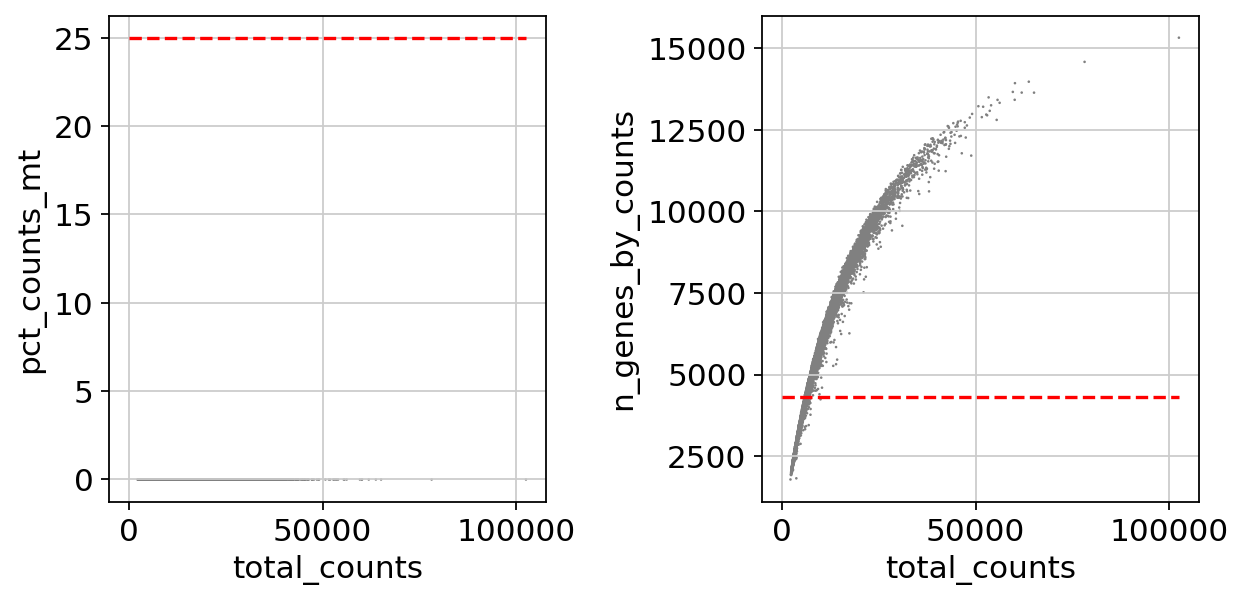

In [11]:
# plotting
fig, axs = plt.subplots(ncols = 2, figsize = (8,4))
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', ax = axs[0], show=False)
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', ax = axs[1], show = False)

# draw horizontal red lines for thresholds.
axs[0].hlines(y = mito_filter, xmin = 0, xmax = max(adata.obs['total_counts']), color = 'red', ls = 'dashed')
axs[1].hlines(y = n_counts_filter, xmin = 0, xmax = max(adata.obs['total_counts']), color = 'red', ls = 'dashed')

fig.tight_layout()
plt.show()

In [12]:
# adata = adata[adata.obs.n_genes_by_counts < n_counts_filter, :]
# adata = adata[adata.obs.pct_counts_mt < mito_filter, :]
# adata

## Data normalization
Raw count matrix, `adata.raw`, is needed for downstream analyses. 

If cells have been removed in doublet removal, re-normalization is necessary. 

In [13]:
# find top 2000 highly-variable genes
filter_result = sc.pp.filter_genes_dispersion(adata.X,
                                              flavor='cell_ranger',
                                              n_top_genes=3000,
                                              log=False)
# subset genes
adata = adata[:, filter_result.gene_subset]

# only include cell types of interest
adata.obs.ident.unique()
cell_of_interest = adata.obs.index[~adata.obs.ident.isin([
    "Endothelial Cells (Non-Neural Cells)",
    "GABAergic Interneurons",
    "Purkinje Cells",
    "Ventricular Zone Progenitors (GABAergic)",
    "GABAergic Cerebellar Nuclei Neurons",
])]
adata = adata[cell_of_interest, :]

In [14]:
# keep raw cont data before log transformation
adata.raw = adata
adata.layers["raw_count"] = adata.raw.X.copy()

In [15]:
# sc.pp.normalize_total(adata, target_sum=1e4)
# sc.pp.log1p(adata)
# sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
# adata = adata[:, adata.var.highly_variable]
# sc.pp.scale(adata, max_value=10)

In [16]:
# Log transformation and scaling
sc.pp.log1p(adata)
sc.pp.scale(adata)

## Dimension reduction and clustering

Parallels the ScanPy notebook as closely as possible. Note: Uses PAGA-initialized force-directed graphs to stay in-line with previous ScanPy pipeline used for CellOracle. 

In [17]:
# PCA
sc.tl.pca(adata, svd_solver='arpack') # default svd_solver='arpack'

# Diffusion map
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)

sc.tl.diffmap(adata)

# Calculate neighbours based on diffusion map
sc.pp.neighbors(adata, n_neighbors=15, use_rep='X_diffmap')

/arc/project/st-dg0ldo-1/jupyter/ScenicPlusEnv/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/arc/project/st-dg0ldo-1/jupyter/ScenicPlusEnv/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/arc/project/st-dg0ldo-1/jupyter/ScenicPlusEnv/l

In [18]:
# cluster cells 
sc.tl.leiden(adata, resolution = 0.2)

In [19]:
# PAGA graph construction
sc.tl.paga(adata, groups='leiden')

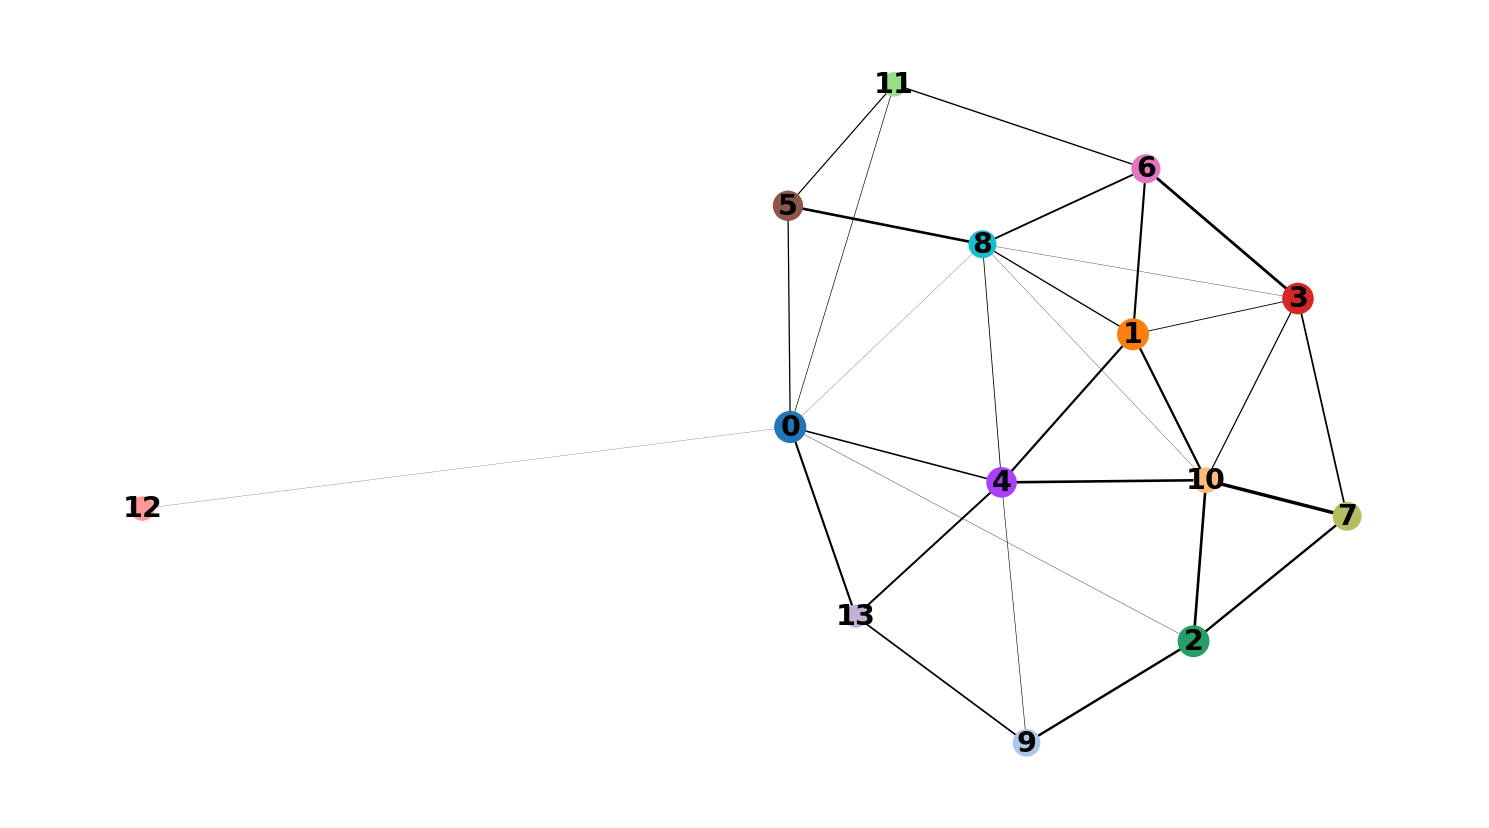

In [20]:
plt.rcParams["figure.figsize"] = [10, 6]
sc.pl.paga(adata)

In [21]:
sc.tl.draw_graph(adata, init_pos='paga', random_state=123)

/arc/project/st-dg0ldo-1/jupyter/ScenicPlusEnv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


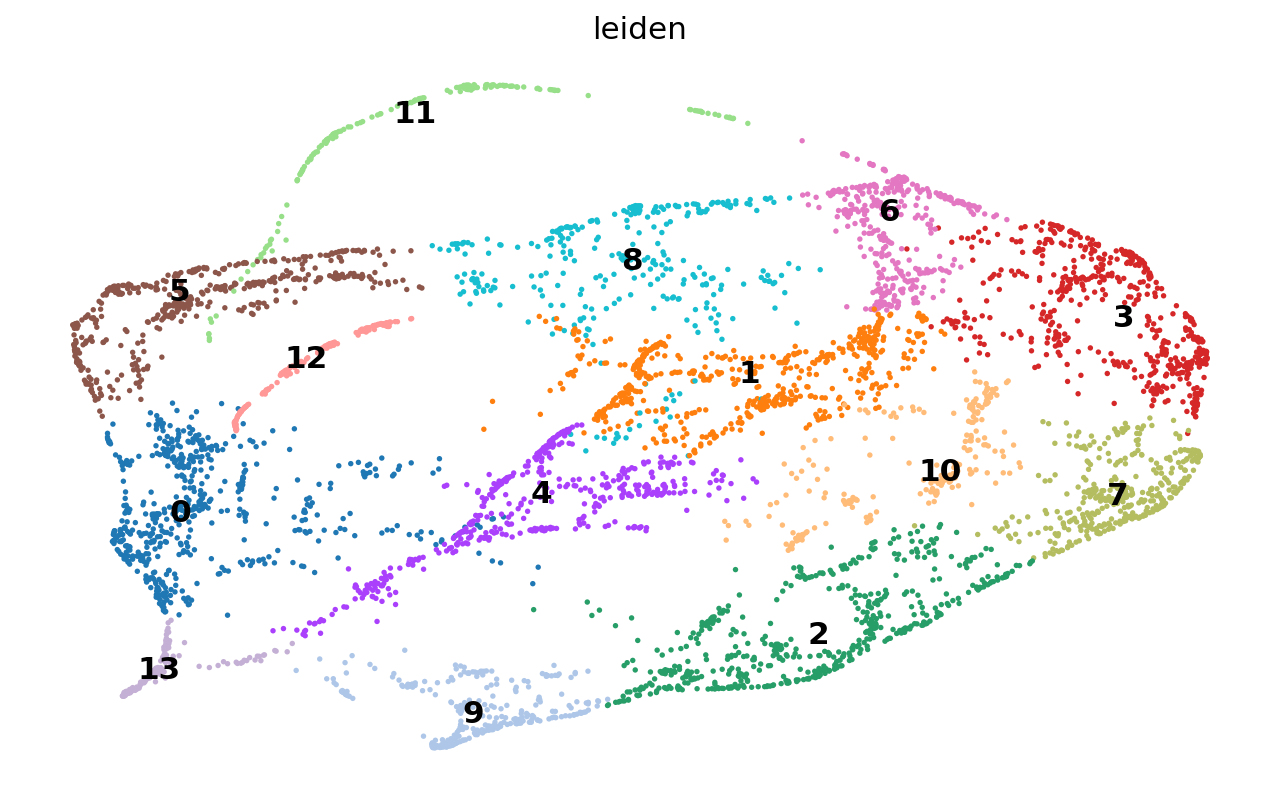

In [22]:
sc.pl.draw_graph(adata, color='leiden', legend_loc='on data')

/arc/project/st-dg0ldo-1/jupyter/ScenicPlusEnv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/arc/project/st-dg0ldo-1/jupyter/ScenicPlusEnv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


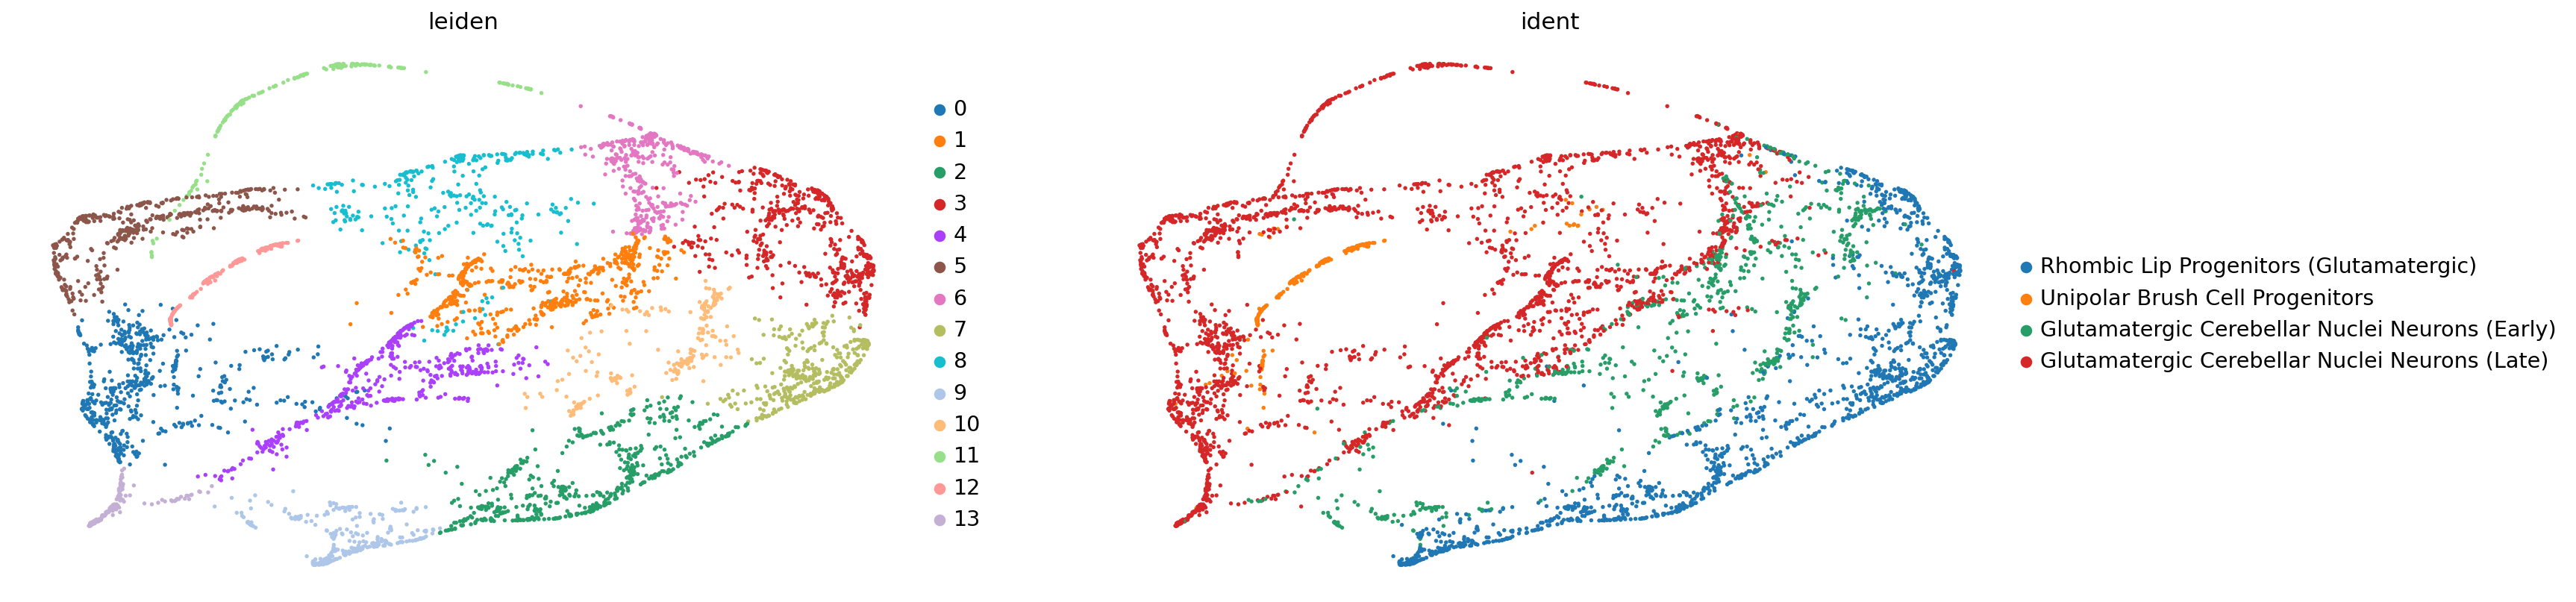

In [23]:
# check result
sc.pl.draw_graph(adata, color=['leiden', 'ident'])

In [24]:
tmp_df = adata.obs.groupby(['leiden', 'ident']).size().unstack(fill_value=0)
tmp_df = (tmp_df / tmp_df.sum(0)).fillna(0)
leiden_to_annotation = tmp_df.idxmax(1).to_dict()
leiden_to_annotation

{'0': 'Glutamatergic Cerebellar Nuclei Neurons (Late)',
 '1': 'Glutamatergic Cerebellar Nuclei Neurons (Early)',
 '2': 'Rhombic Lip Progenitors (Glutamatergic)',
 '3': 'Rhombic Lip Progenitors (Glutamatergic)',
 '4': 'Glutamatergic Cerebellar Nuclei Neurons (Early)',
 '5': 'Glutamatergic Cerebellar Nuclei Neurons (Late)',
 '6': 'Glutamatergic Cerebellar Nuclei Neurons (Late)',
 '7': 'Rhombic Lip Progenitors (Glutamatergic)',
 '8': 'Glutamatergic Cerebellar Nuclei Neurons (Late)',
 '9': 'Rhombic Lip Progenitors (Glutamatergic)',
 '10': 'Glutamatergic Cerebellar Nuclei Neurons (Early)',
 '11': 'Glutamatergic Cerebellar Nuclei Neurons (Late)',
 '12': 'Unipolar Brush Cell Progenitors',
 '13': 'Glutamatergic Cerebellar Nuclei Neurons (Late)'}

### Subclustering the rhombic lip progenitors into the interior and outer face. 

As written by [Yeung et al. (2014)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4160781/), the two faces have complimentary markers. The exterior face is considered more lineage-committed than the interior.  
- interior face: Wls, Msx1, Sox2
- exterior face: Atoh1, Pax6, *notably Wls-NEGATIVE*

A note about Lmx1a: 
- E13.5: marks the CN neuron precursors migrating to the nuclear transitory zone 
- E15.5 to E18.5: marks UBCs. However, whether the UBC progenitors migrate into the eRL before exiting through the white matter is still unknown!

**Looking at the 4 leiden clusters, I am classifying 2, 9 as exterior (more lineage committed), and 3, 7 as interior (more progenitor).** 
- Admittedly, this is not a clean split! Whether keeping this reannotation is more productive will be discussed in a lab meeting. 

In [43]:
# Currently, leiden clusters 2, 3, 7, 9 are RL progenitors
rl_adata = adata[adata.obs['leiden'].isin(["2", "3", "7", "9"])]

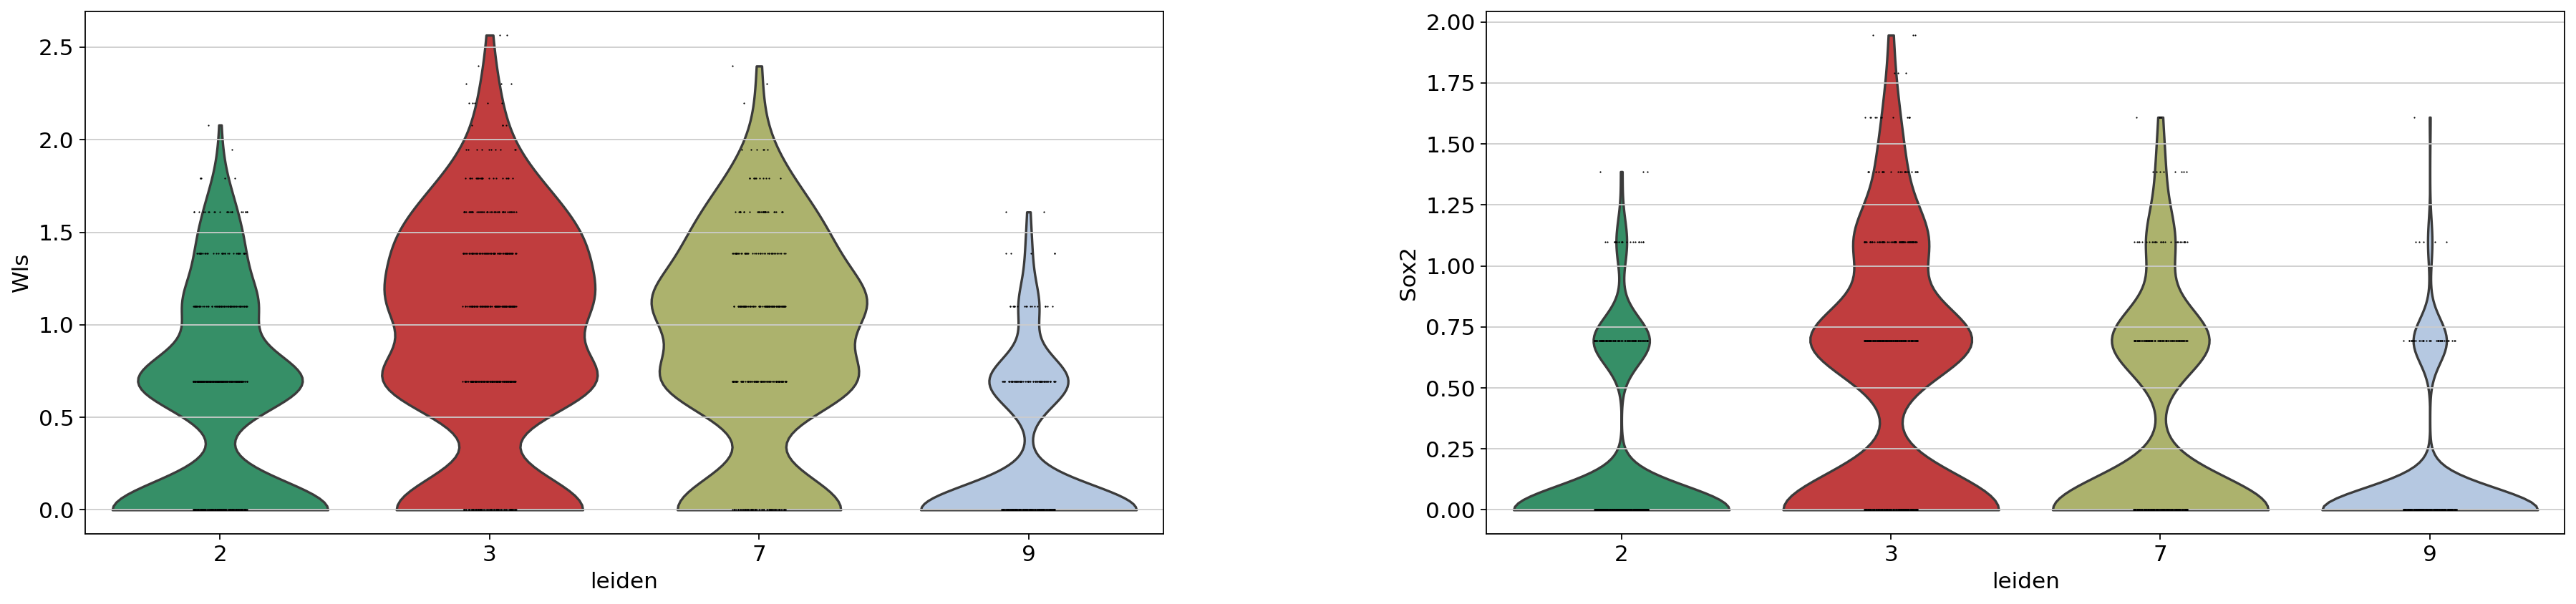

In [44]:
sc.pl.violin(rl_adata, ["Wls", "Sox2"], groupby="leiden") # no Msx1!

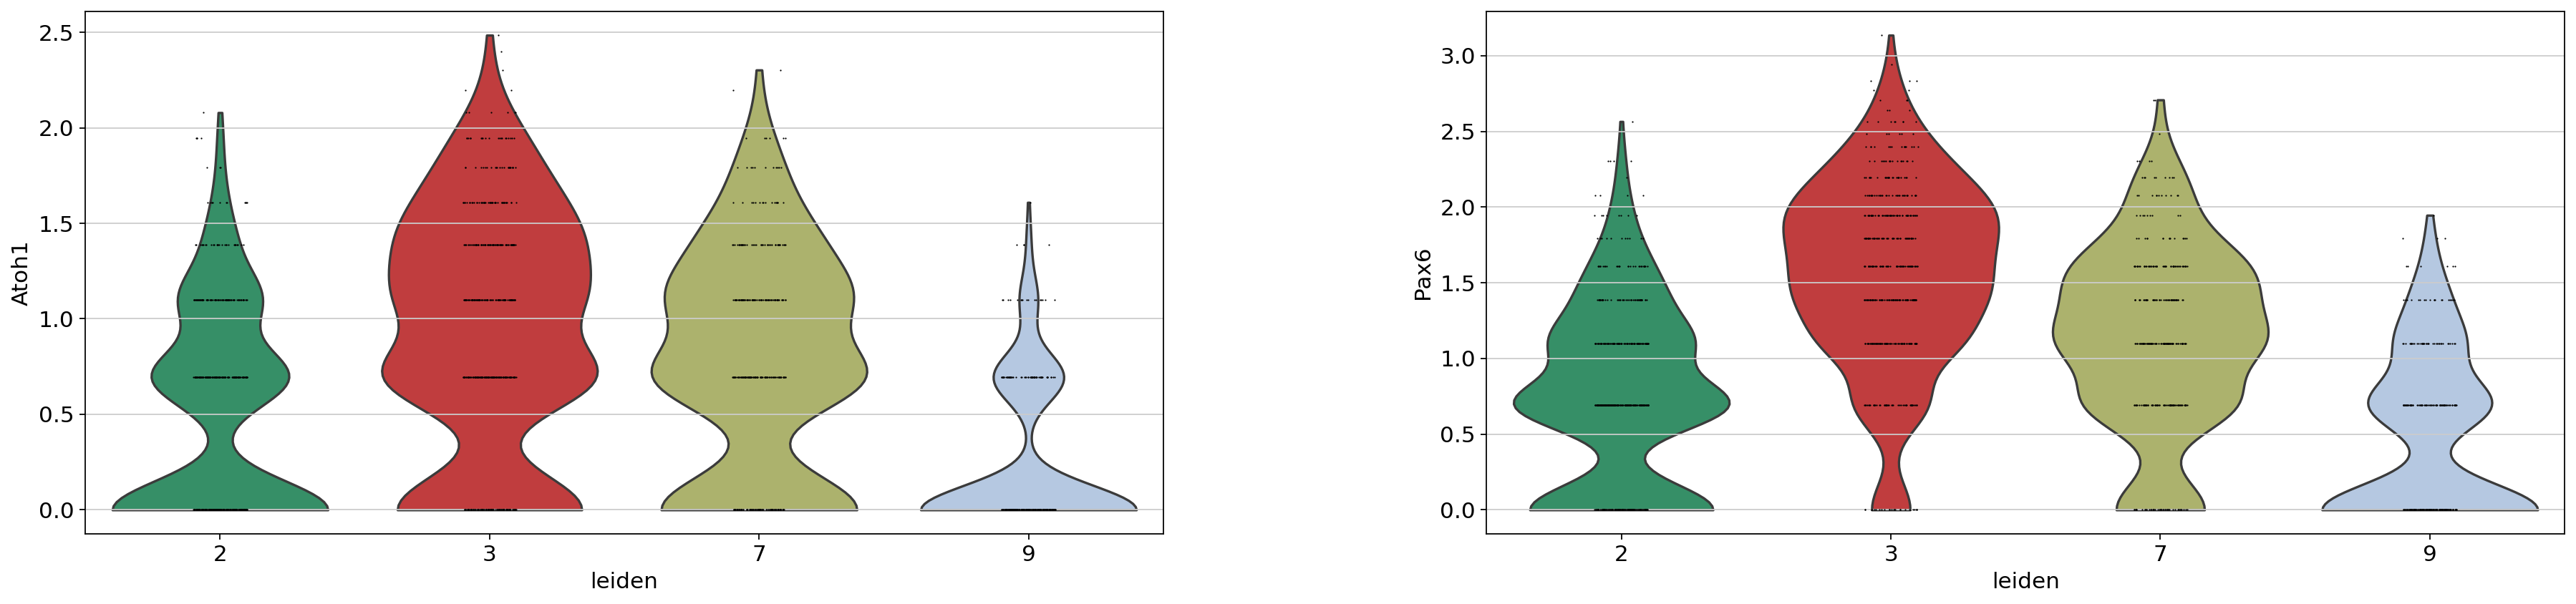

In [45]:
sc.pl.violin(rl_adata, ["Atoh1", "Pax6"], groupby="leiden") # no Lmx1a

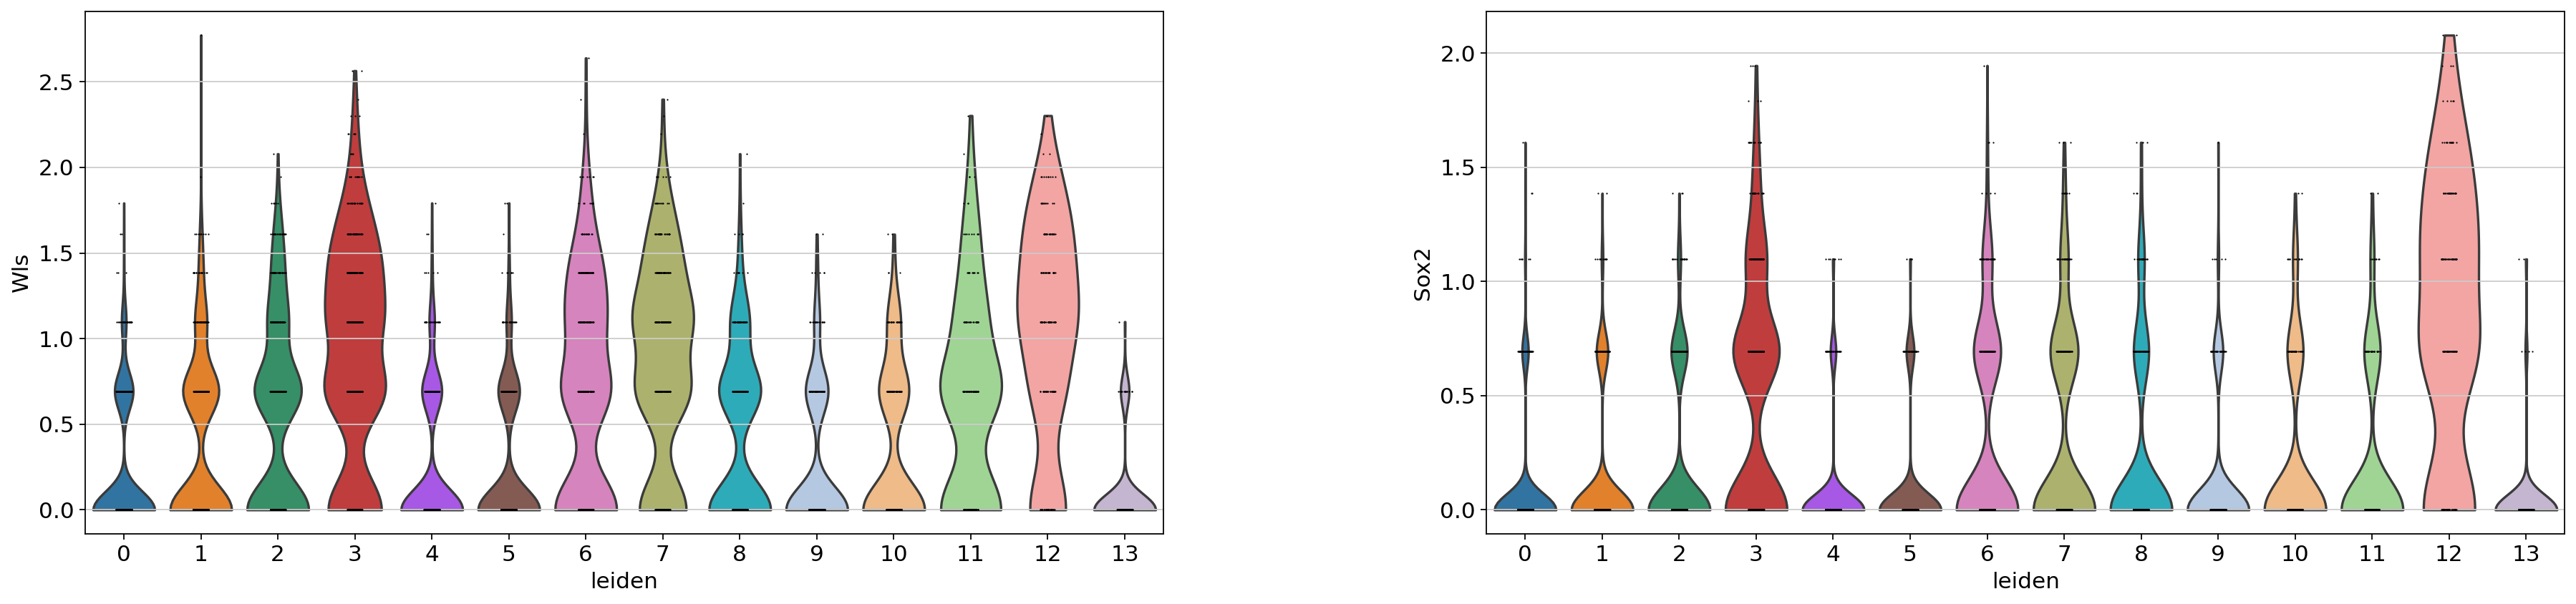

In [46]:
sc.pl.violin(adata, ["Wls", "Sox2"], groupby="leiden") # no Msx1!

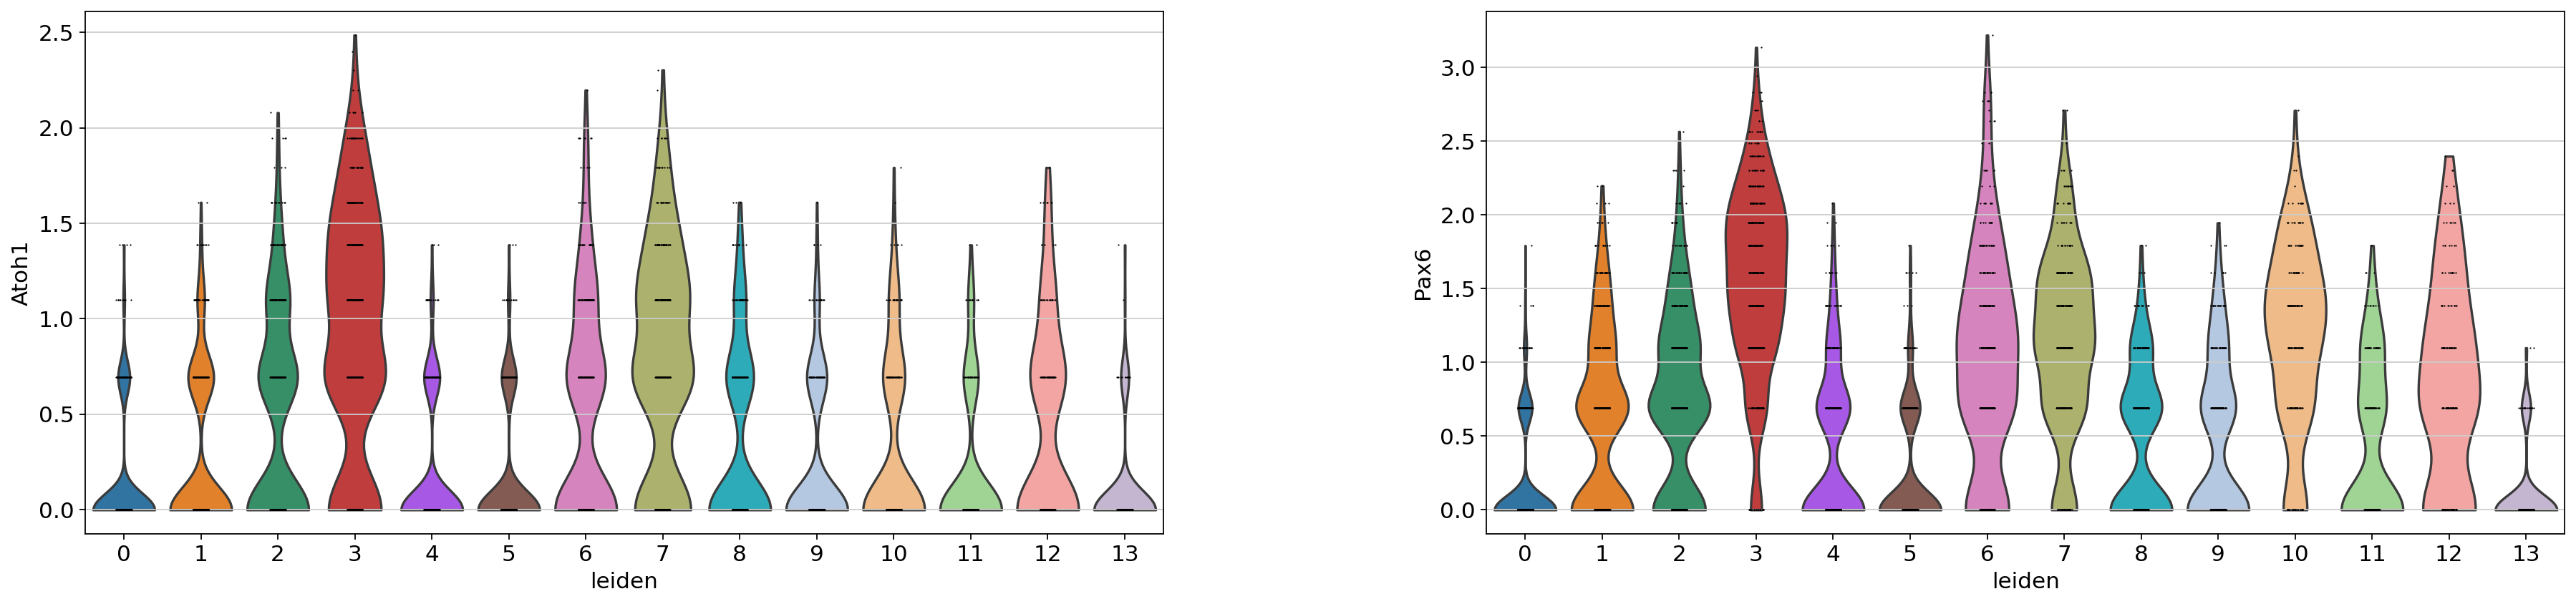

In [47]:
sc.pl.violin(adata, ["Atoh1", "Pax6"], groupby="leiden") # no Lmx1a

In [48]:
# renaming clusters of interest
leiden_to_annotation['2'] = 'Rhombic Lip Progenitors (exterior)'
leiden_to_annotation['9'] = 'Rhombic Lip Progenitors (exterior)'

leiden_to_annotation['3'] = 'Rhombic Lip Progenitors (interior)'
leiden_to_annotation['7'] = 'Rhombic Lip Progenitors (interior)'

In [49]:
# final formatting: remove whitespace 
leiden_to_annotation = {cluster: leiden_to_annotation[cluster].replace(' ', '_') for cluster in leiden_to_annotation.keys()}
leiden_to_annotation

{'0': 'Glutamatergic_Cerebellar_Nuclei_Neurons_(Late)',
 '1': 'Glutamatergic_Cerebellar_Nuclei_Neurons_(Early)',
 '2': 'Rhombic_Lip_Progenitors_(exterior)',
 '3': 'Rhombic_Lip_Progenitors_(interior)',
 '4': 'Glutamatergic_Cerebellar_Nuclei_Neurons_(Early)',
 '5': 'Glutamatergic_Cerebellar_Nuclei_Neurons_(Late)',
 '6': 'Glutamatergic_Cerebellar_Nuclei_Neurons_(Late)',
 '7': 'Rhombic_Lip_Progenitors_(interior)',
 '8': 'Glutamatergic_Cerebellar_Nuclei_Neurons_(Late)',
 '9': 'Rhombic_Lip_Progenitors_(exterior)',
 '10': 'Glutamatergic_Cerebellar_Nuclei_Neurons_(Early)',
 '11': 'Glutamatergic_Cerebellar_Nuclei_Neurons_(Late)',
 '12': 'Unipolar_Brush_Cell_Progenitors',
 '13': 'Glutamatergic_Cerebellar_Nuclei_Neurons_(Late)'}

In [51]:
adata.obs['celltype'] = [leiden_to_annotation[cluster_id] for cluster_id in adata.obs['leiden']]
del(leiden_to_annotation)
del(tmp_df)

/arc/project/st-dg0ldo-1/jupyter/ScenicPlusEnv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


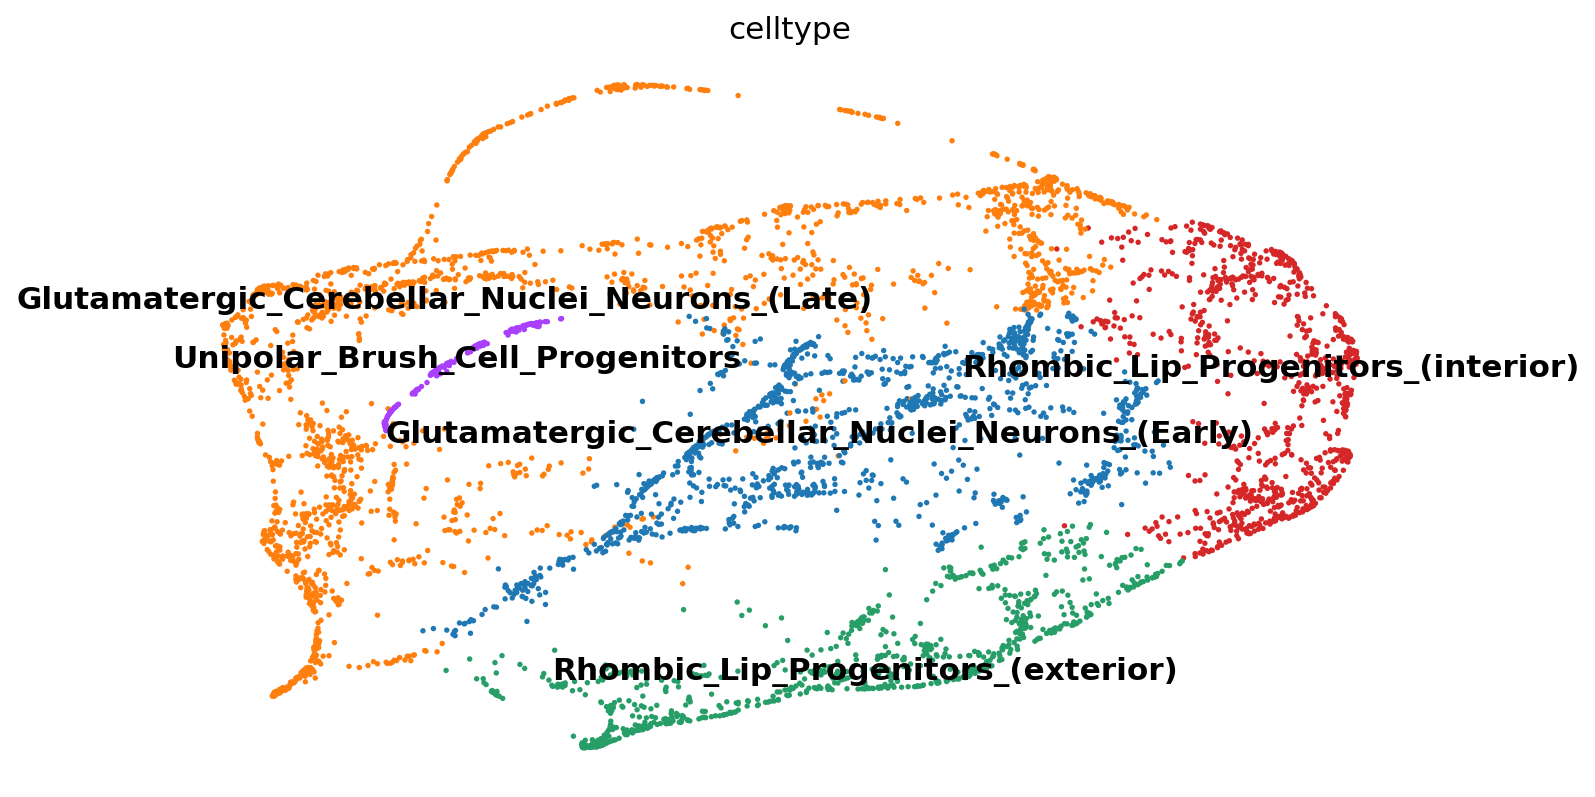

In [52]:
sc.pl.draw_graph(adata, color='celltype', legend_loc='on data')

In [54]:
adata.write(os.path.join(work_dir, 'scRNA/adata_combined_e12_e14_GSE178546.h5ad'), compression='gzip')